In [1]:
# Week 1: Data Collection, EDA, NLP Preprocessing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load dataset
df = pd.read_csv(r"C:\Users\student\Downloads\complete_task_dataset.csv")
df.dropna(inplace=True)

In [3]:
# EDA
print(df.info())
print(df.describe())
print(df['status'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   task_id           500 non-null    int64  
 1   task_description  500 non-null    object 
 2   created_at        500 non-null    object 
 3   due_date          500 non-null    object 
 4   assigned_to       500 non-null    object 
 5   priority          500 non-null    object 
 6   status            500 non-null    object 
 7   category          500 non-null    object 
 8   estimated_hours   500 non-null    float64
 9   actual_hours      500 non-null    float64
 10  user_workload     500 non-null    float64
 11  user_skill_level  500 non-null    object 
dtypes: float64(3), int64(1), object(8)
memory usage: 47.0+ KB
None
          task_id  estimated_hours  actual_hours  user_workload
count  500.000000       500.000000    500.000000     500.000000
mean   250.500000         6.448400      6

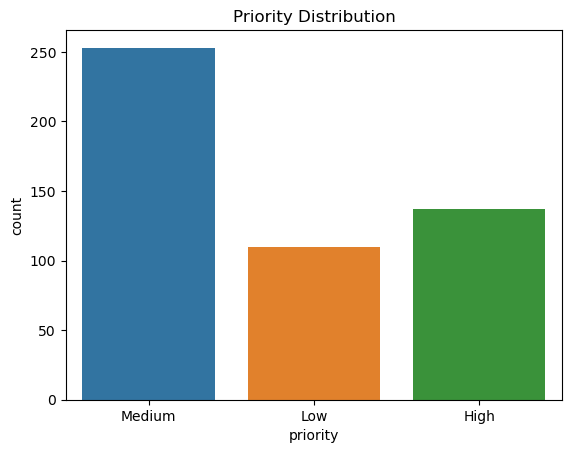

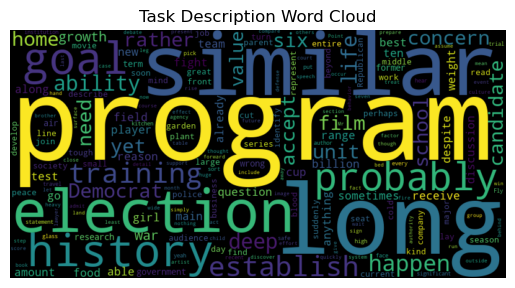

In [4]:
# Visualization
sns.countplot(x='priority', data=df)
plt.title("Priority Distribution")
plt.show()

wordcloud = WordCloud(width=800, height=400).generate(' '.join(df['task_description']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Task Description Word Cloud")
plt.show()

In [5]:
# Text Preprocessing
def preprocess(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text.lower())
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stopwords.words('english') and len(w) > 2]
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(w) for w in tokens])

df['clean_description'] = df['task_description'].apply(preprocess)


In [6]:
# Week 2: BERT Embeddings and Classification

from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif

In [7]:
# BERT Embeddings
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(texts):
    embeddings = []
    for text in tqdm(texts):
        inputs = bert_tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        embeddings.append(outputs.last_hidden_state[:, 0, :].squeeze().numpy())
    return np.array(embeddings)

bert_embeddings = get_bert_embeddings(df['clean_description'].tolist())

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [08:19<00:00,  1.00it/s]


In [8]:
# Task Classification with BERT + SVM
X = bert_embeddings
y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm = SVC(kernel='linear', class_weight='balanced')
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)
print("\nSVM (BERT) Category Classification Report:")
print(classification_report(y_test, svm_preds))


SVM (BERT) Category Classification Report:
              precision    recall  f1-score   support

         Bug       0.50      0.50      0.50        36
     Feature       0.41      0.52      0.46        33
 Improvement       0.26      0.19      0.22        31

    accuracy                           0.41       100
   macro avg       0.39      0.40      0.39       100
weighted avg       0.40      0.41      0.40       100



In [9]:
# Week 3: Priority Prediction with Random Forest/XGBoost, SMOTE, GridSearch

le = LabelEncoder()
df['priority_encoded'] = le.fit_transform(df['priority'])

features = df[['estimated_hours', 'actual_hours', 'user_workload']].copy()
df['workload_score'] = df['user_workload'] / (df['estimated_hours'] + 1)
features['workload_score'] = df['workload_score']
labels = df['priority_encoded']

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(features, labels)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [10]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print("\nRandom Forest Priority Prediction Report:")
print(classification_report(y_test, rf_preds))


Random Forest Priority Prediction Report:
              precision    recall  f1-score   support

           0       0.53      0.54      0.54        48
           1       0.54      0.58      0.56        52
           2       0.49      0.44      0.46        52

    accuracy                           0.52       152
   macro avg       0.52      0.52      0.52       152
weighted avg       0.52      0.52      0.52       152



In [11]:
# XGBoost with GridSearchCV
xgb = XGBClassifier(eval_metric='mlogloss')
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [6, 8],
    'learning_rate': [0.05, 0.1]
}
grid = GridSearchCV(xgb, param_grid, cv=3)
grid.fit(X_train, y_train)
print("\nBest XGBoost Params:", grid.best_params_)


Best XGBoost Params: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100}



Final XGBoost Priority Prediction Report:
              precision    recall  f1-score   support

           0       0.51      0.52      0.52        48
           1       0.53      0.56      0.54        52
           2       0.52      0.48      0.50        52

    accuracy                           0.52       152
   macro avg       0.52      0.52      0.52       152
weighted avg       0.52      0.52      0.52       152



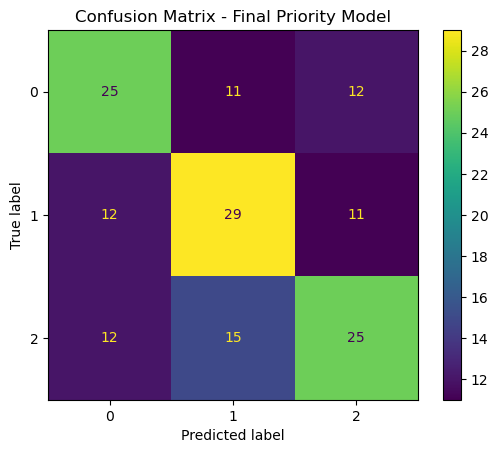

In [12]:
final_model = grid.best_estimator_
final_preds = final_model.predict(X_test)
print("\nFinal XGBoost Priority Prediction Report:")
print(classification_report(y_test, final_preds))

ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test)
plt.title("Confusion Matrix - Final Priority Model")
plt.show()

In [13]:
# Export Clean Dataset
df.to_csv("cleaned_task_dataset.csv", index=False)

In [ ]:
# GitHub (manual step)
# git init
# git add .
# git commit -m "Final Task Management Project"
# git remote add origin <your_repo_url>
# git push -u origin master